# Introducción

En esta notebook se explora como abordar el problema de regreson linal desde una perspectiva **probabilística**, en lugar de ajuatar una recta que minimice los errores (Least Squares). 

## ¿Por qué una visión probabilística? 
Cuando hacemos una regresion, en general no esperamos que los datos sigan una línea perfeca: nuestras observaciones están *contaminadas* por ruido. Este ruido muchas veces se modela como una *variable aleatoria*, lo que nos lleva a formular el modelo desde una distribución de probabilidad en lugar de una simple ecuación determinista. 

## Modelo probabilístico

Asumimos que los datos se generaron a partir del siguiente proceso: 
$$y = \textbf{x}^T\theta + \epsilon, ~~\text{con} ~~\epsilon \sim N(0, \sigma^2)$$

Desde una perspectiva probabilística, esto se traduce en el siguiente modelo de *verosimilitud* (likehood): 

$$
p(y|\mathbf{x}, \boldsymbol{\theta}) = \mathcal{N}(y | \mathbf{x}^T \boldsymbol{\theta}, \sigma^2)
$$

Donde:
- $\mathbf{x} \in \mathbb{R}^D$ es el vector de entrada,
- $\boldsymbol{\theta}$ son los parámetros que queremos aprender,
- $\sigma^2$ es la varianza del ruido (suponemos que es conocida o fija por simplicidad).

### ¿C+omo estimar los parámetros?

El objetivo ahora es inferir los valores más razonables para $\boldsymbol{\theta}$ dado  un conjunto de datos observados $\mathcal{D} = \left\{ (\mathbf{x}_n, y_n) \mid n = 1, 2, \dots, N \right\}$. Existen dos enfoques principales para resolver esto: 

1. **Maximum Likehood Estimation (MLE)**
- Encuentra los parámetros que maximizan la probabilidad de observar los datos dados. 
- No se asume conocimeinto previo sobre los parámetros. 
2. **Maximum A Posteriori (MAP)**
- Similar a MLE, pero incorpora una *distribución a priori* (prior distribution) sobre los parámetros. 
- Esto actúa como una forma de **regularización**, útil cuando tenemos pocos datos o mucho ruido. 

### ¿Qué haremos en el siguiente notebook?

1. Simularemos un conjunto de datos con una relación lineal y ruido.
2. Derivaremos las soluciones analíticas para MLE y MAP.
3. Implementaremos ambas soluciones.
4. Compararemos visualmente los resultados.
5. Discutiremos sus diferencias y cuándo conviene usar cada una.


## Simulación de datos

En el siguiente script se generan un conjunto de datos sintéticos siguiendo un modelo de regresion lineal simple. Generamos puntos $x$ equiespaciados y las correspondientes salidas $y$ (targets) con *ruido gaussiano*, tal como asumimos en el modelo probabilístico: 
$$y = \theta_0+\theta_1 x + \epsilon, ~~\text{con} ~~ \epsilon\sim N(0, \sigma^2)$$


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import add_dummy_feature

In [31]:
def generate_random_linear_data(theta_0: float = 4,
                                theta_1: int = 3,
                                n_samples: int = 100,
                                noise_std: float = 1.0,
                                seed: int = 0):
    """
    Genera datos sintéticos para regresión lineal: y = theta_0 + theta_1 * x + ruido

    Retorna:
    - X_b: matriz de características con columna de bias incluida (matriz de diseño)
    - y: vector objetivo
    - true_theta: vector con los parámetros reales [theta_0, theta_1]
    """
    rng = np.random.default_rng(42)   # Generador aleatorio con semilla de reproducibilidad fija

    # Parámetros verdaderos
    sigma = 1.0  # stdev del ruido
    X = 2 * rng.random(size=(n_samples, 1))  # valores de x entre 0 y 2
    true_theta = np.array([[theta_0], [theta_1]])  # intercepto, pendiente
    noise = rng.normal(0, noise_std, size=(n_samples, 1))
    y = true_theta[0] + true_theta[1] * X + noise
    X_b = add_dummy_feature(X)  # añade columna de 1s (bias)
    return X_b, y, true_theta

In [32]:
X_b, y, theta_true = generate_random_linear_data()

In [33]:
X_b.shape, y.shape, *theta_true

((100, 2), (100, 1), array([4]), array([3]))

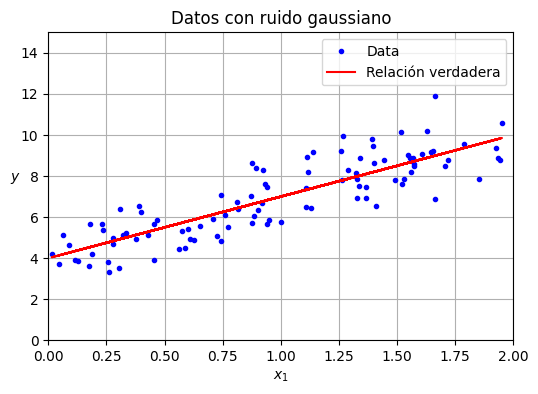

In [50]:
plt.figure(figsize=(6, 4))
plt.plot(X_b[:, 1], y, "b.", label='Data')
plt.plot(X_b[:, 1], X_b @ theta_true, color="red", label="Relación verdadera")
plt.title('Datos con ruido gaussiano')
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend()
plt.show()

## Estimación por Maxima Verosimilitud (MLE)

Considerando que el ruido sigue una distrubición gaussiana con varianza conocida $\sigma^2$, el modelo probabilístico para cada punto es: 
$$
y_n = \boldsymbol{x}_n^T \boldsymbol{\theta} + \epsilon_n, \quad \epsilon_n \sim \mathcal{N}(0, \sigma^2)
$$

donde $\boldsymbol{x}_n = [1, x_n]^T$ incluye un término constante (bias) para modelar el intercepto.

La estimación por máxima verosimilitud (MLE) consiste en encontrar los parámetros $\bm{\theta}$ que maximizan la verosimilitud de los datos observados. Dado que asumimos que las observaciones $y_n$ son generadas según una distribución gaussiana centrada en $\boldsymbol{x}_n^T\boldsymbol{\theta}$ con varianza $\sigma^2$, la función de verosimilitud para el conjunto de entrenamiento es:

$$
\mathcal{L}(\boldsymbol{\theta}) = p(\boldsymbol{y}|\boldsymbol{X}, \bm{\theta}) = \prod_{n=1}^{N} \mathcal{N}(y_n|\boldsymbol{x}_n^T\boldsymbol{\theta}, \sigma^2)
$$

Para facilitar la optimización, trabajamos con el logaritmo de la verosimilitud (log-likelihood):

$$
\log \mathcal{L}(\boldsymbol{\theta}) = \sum_{n=1}^{N} \log \left[ \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y_n - \boldsymbol{x}_n^T\boldsymbol{\theta})^2}{2\sigma^2} \right) \right]
$$

Simplificando:

$$
\log \mathcal{L}(\boldsymbol{\theta}) = -\frac{N}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2} \sum_{n=1}^{N} (y_n - \boldsymbol{x}_n^T\boldsymbol{\theta})^2
$$

Como el primer término no depende de $\boldsymbol{\theta}$, maximizar la log-verosimilitud equivale a minimizar la siguiente función:

$$
\sum_{n=1}^{N} (y_n - \boldsymbol{x}_n^T\bm{\theta})^2
$$

Esta expresión corresponde a la **función de error cuadrático medio** o **Mean Squared Error (MSE)** (sin la constante de normalización):

$$
\mathcal{L}(\boldsymbol{\theta}) = \|\boldsymbol{y} - \boldsymbol{X}\bm{\theta} \|^2
$$

Por tanto, el objetivo de la regresión lineal es encontrar los parámetros $\bm{\theta}$ que minimicen la suma de los errores cuadrados entre las predicciones $\bm{X}\bm{\theta}$ y los valores reales $\bm{y}$.

Para encontrar el mínimo, derivamos con respecto a $\bm{\theta}$ e igualamos a cero:

$$
\frac{\partial}{\partial \bm{\theta}} \|\bm{y} - \bm{X}\bm{\theta} \|^2 = -2\bm{X}^T(\bm{y} - \bm{X}\bm{\theta}) = 0
$$

Resolviendo esta ecuación obtenemos la **solución cerrada (closed-form)** de la regresión lineal:

$$
\bm{\theta}_{\text{MLE}} = (\bm{X}^T\bm{X})^{-1} \bm{X}^T \bm{y}
$$

Esta expresión se conoce como la **solución de los mínimos cuadrados ordinarios** (OLS: *Ordinary Least Squares*).



In [ ]:
# Segun los datos, X_b es la matriz de diseño, que posee una columna de 1s para el intercepto

# Estimación MLE
theta_mle = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y 

In [47]:
print(*theta_mle)
print(type(theta_mle[0][0]))

[3.94869973] [3.03831479]
<class 'numpy.float64'>


In [49]:
print(f"Parámetros estimados (MLE): theta_0 = {theta_mle[0][0]:.3f}, theta_1 = {theta_mle[1][0]:.3f}")

Parámetros estimados (MLE): theta_0 = 3.949, theta_1 = 3.038


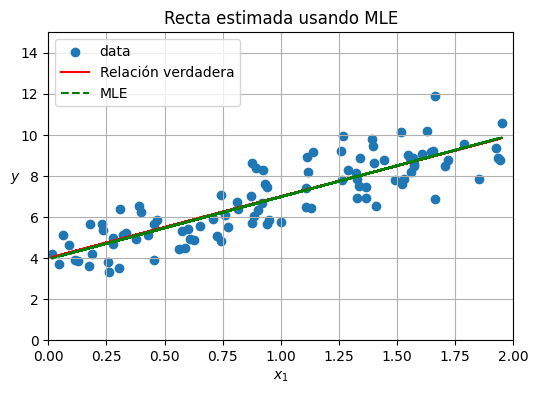

In [53]:
plt.figure(figsize=(6, 4))
plt.scatter(X_b[:, 1], y, label='data')
plt.plot(X_b[:, 1], X_b @ theta_true, color="red", label="Relación verdadera")
plt.plot(X_b[:, 1], X_b @ theta_mle, color='green', linestyle="--", label='MLE')
plt.title("Recta estimada usando MLE")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid(True)
plt.legend()
plt.show()

## Estimación por Maxima a Posteriori (MAP)

La estimación MAP extiende MLE incorporando conocimiento previo sobre los parámetros $\boldsymbol{\theta}$ mediante un **priori**. Asumimos que: 
$$
p(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta} | \mathbf{0}, b^2 \mathbf{I})
$$

La distribución posterior de los parámetros es:

$$
p(\boldsymbol{\theta} | \mathbf{X}, \mathbf{y}) \propto p(\mathbf{y} | \mathbf{X}, \boldsymbol{\theta}) \cdot p(\boldsymbol{\theta})
$$

Maximizar la log-posterior equivale a minimizar la siguiente función de costo:

$$
\mathcal{L}(\boldsymbol{\theta}) = \sum_{n=1}^{N} (y_n - \boldsymbol{x}_n^T \boldsymbol{\theta})^2 + \lambda \|\boldsymbol{\theta}\|^2
$$

donde $\lambda = \frac{\sigma^2}{b^2}$ es un hiperparámetro de regularización.

La solución analítica se obtiene de manera similara a MLE, con resultado:

$$
\hat{\boldsymbol{\theta}}_{\text{MAP}} = (\mathbf{X}^T \mathbf{X} + \lambda \mathbf{I})^{-1} \mathbf{X}^T \mathbf{y}
$$

Este resultado corresponde a la **regresión ridge**.



In [55]:
np.eye(X_b.shape[1])

array([[1., 0.],
       [0., 1.]])

In [63]:
# Hiperparámetro de regularización
lambda_reg = 1.0

# Matriz identidad
I = np.eye(X_b.shape[1])

# Estimación MAP
theta_map = np.linalg.inv(X_b.T @ X_b +  lambda_reg * I) @ X_b.T @ y

In [64]:
print(f"Parámetros estimados (MAP): theta_0 = {theta_map[0][0]:.3f}, theta_1 = {theta_map[1][0]:.3f}")

Parámetros estimados (MAP): theta_0 = 3.886, theta_1 = 3.063


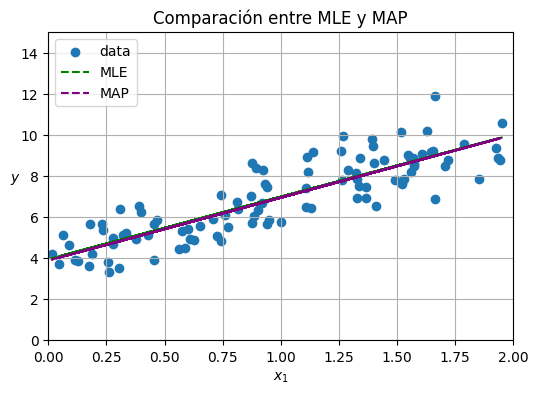

In [66]:
plt.figure(figsize=(6, 4))
plt.scatter(X_b[:, 1], y, label='data')
plt.plot(X_b[:, 1], X_b @ theta_mle, color='green', linestyle="--", label='MLE')
plt.plot(X_b[:, 1], X_b @ theta_map, color='purple', linestyle="--", label='MAP')
plt.title("Comparación entre MLE y MAP")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid(True)
plt.legend()
plt.show()

## Comparación: MLE vs MAP

Ahora que tenemos ambos estimadores, es útil comparar sus resultados: 

In [70]:
print("=== Parámetros Estimados ===")
print(f"Verdaderos:       theta_0 = {theta_true[0][0]:.3f}, theta_1 = {theta_true[1][0]:.3f}")
print(f"MLE estimado:     theta_0 = {theta_mle[0][0]:.3f}, theta_1 = {theta_mle[1][0]:.3f}")
print(f"MAP estimado:     theta_0 = {theta_map[0][0]:.3f}, theta_1 = {theta_map[1][0]:.3f}")

=== Parámetros Estimados ===
Verdaderos:       theta_0 = 4.000, theta_1 = 3.000
MLE estimado:     theta_0 = 3.949, theta_1 = 3.038
MAP estimado:     theta_0 = 3.886, theta_1 = 3.063


In [71]:
from sklearn.metrics import mean_squared_error

In [ ]:
y_true = X_b @ theta_true
y_mle = X_b @ theta_mle
y_map = X_b @ theta_map

mse_mle = mean_squared_error(y_true, y_mle)
mse_map = mean_squared_error(y_true, y_map)


## Conclusiones